#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cat vs. Dog Image Classification
## Exercise 1: Building a Convnet from Scratch
**_Estimated completion time: 20 minutes_**

In this exercise, we will build a classifier model from scratch that is able to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-10-04 18:22:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.197.128, 173.194.198.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   158MB/s    in 0.4s    

2021-10-04 18:22:19 (158 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.496.jpg', 'cat.560.jpg', 'cat.304.jpg', 'cat.613.jpg', 'cat.504.jpg', 'cat.759.jpg', 'cat.448.jpg', 'cat.183.jpg', 'cat.208.jpg', 'cat.0.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

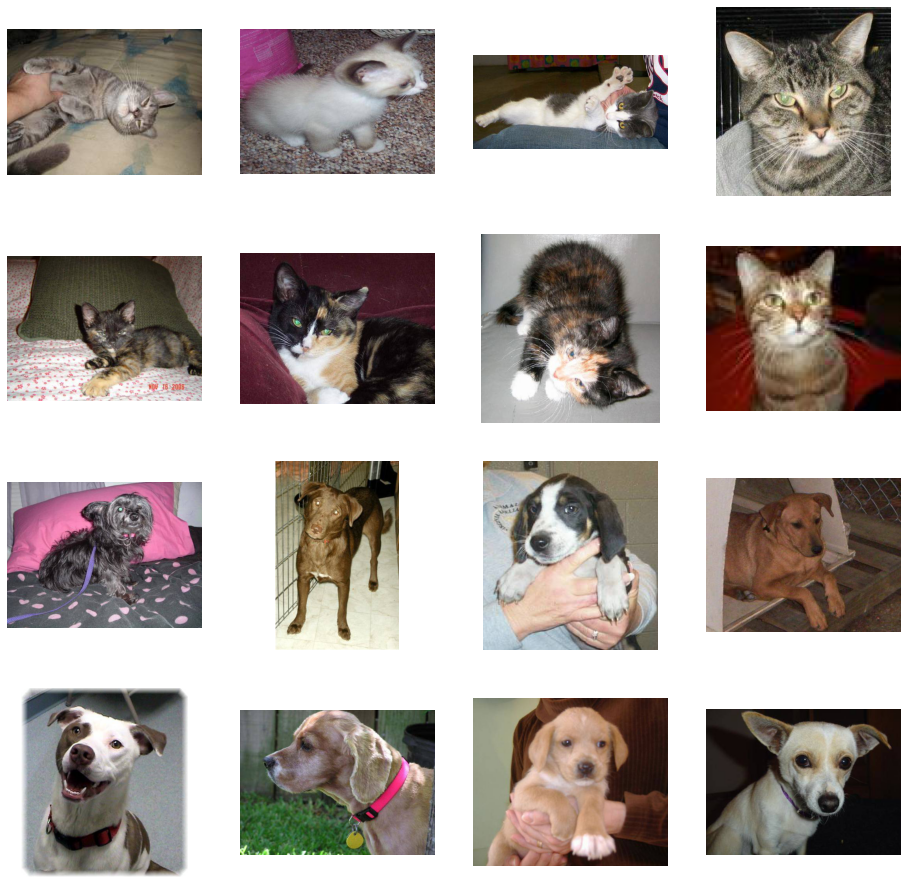

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Convnet from Scratch to Get to 72% Accuracy

The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

**NOTE**: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting (which we'll explore in more depth in Exercise 2.)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
#my implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization


In [ ]:
model1=Sequential()
model1.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(.25))


model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(.25))


model1.add(Flatten())
model1.add(Dense(512,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(.5))
model1.add(Dense(2,activation='softmax'))

model1.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)       

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

#test_generator
test_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')





Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model1.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50 # 1000 images = batch_size * steps
      )

Epoch 1/15
100/100 [==============================] - 13s 125ms/step - loss: 0.7321 - accuracy: 0.6855 - val_loss: 2.5506 - val_accuracy: 0.5000
Epoch 2/15
100/100 [==============================] - 13s 125ms/step - loss: 0.6222 - accuracy: 0.7310 - val_loss: 1.5968 - val_accuracy: 0.5010
Epoch 3/15
100/100 [==============================] - 13s 126ms/step - loss: 0.4670 - accuracy: 0.8030 - val_loss: 1.5279 - val_accuracy: 0.5340
Epoch 4/15
100/100 [==============================] - 13s 126ms/step - loss: 0.3264 - accuracy: 0.8700 - val_loss: 1.0727 - val_accuracy: 0.6210
Epoch 5/15
100/100 [==============================] - 13s 126ms/step - loss: 0.2405 - accuracy: 0.9055 - val_loss: 0.7472 - val_accuracy: 0.6760
Epoch 6/15
100/100 [==============================] - 13s 126ms/step - loss: 0.1760 - accuracy: 0.9310 - val_loss: 0.7558 - val_accuracy: 0.6980
Epoch 7/15
100/100 [==============================] - 13s 126ms/step - loss: 0.1480 - accuracy: 0.9475 - val_loss: 0.8348 - val_ac

Text(0.5, 1.0, 'Training and validation loss')

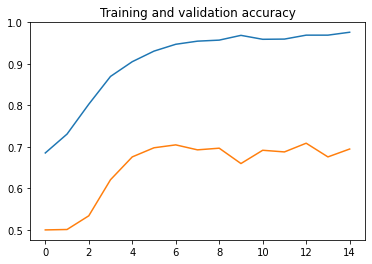

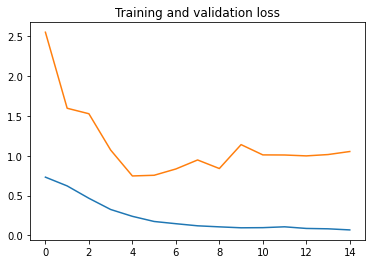

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
import pandas as pd
test_filenames = os.listdir(train_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
import numpy as np
predict=model1.predict(test_generator,steps=np.ceil(nb_samples/15))

In [ ]:
predicted_class_indices=np.argmax(predict, axis=-1)
print(test_generator)


In [ ]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:

filenames=test_generator.filenames
filenames=filenames[:20]
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [ ]:
results

,Filename,Predictions
0,cats/cat.2000.jpg,cats
1,cats/cat.2001.jpg,cats
2,cats/cat.2002.jpg,cats
3,cats/cat.2003.jpg,dogs
4,cats/cat.2004.jpg,cats
5,cats/cat.2005.jpg,cats
6,cats/cat.2006.jpg,dogs
7,cats/cat.2007.jpg,dogs
8,cats/cat.2008.jpg,dogs
9,cats/cat.2009.jpg,cats


## 



--I change the Hyperparamenter like number of filters




-- add the dropout layer so that model not be underfit




-- I use the categorical_entropy agnist of binary_entropy



